# DBSCAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
selected_samples = iris.target < 2
X = iris.data[['petal length (cm)', 'petal width (cm)']][selected_samples]
# Remove duplicates for better visualization
X = X.drop_duplicates()
y = iris.target[selected_samples][X.index]

## Create the Algorithm from Scratch

In [3]:
class DBSCANFromScratch:
    CORE_POINT = 'core_point'
    BORDER_POINT = 'border_point'
    COLORS = ['tab:blue', 'tab:orange']
    PLOT_X1_LIM = [1, 5.1]
    PLOT_X2_LIM = [0.1, 1.8]
    
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.iterated_points = None
        self.predictions = None
        self.cluster_counter = 0

    @staticmethod
    def get_distance_between_points(x_param, x_len):
        x_stacked = np.stack([x_param] * x_len)
        x_repeated = np.repeat(x_param, x_len, axis=0)
        points_dimension = len(x_param[0])
        x_repeated = x_repeated.reshape((x_len, x_len, points_dimension))
        
        return np.linalg.norm(x_stacked - x_repeated, axis=2)

    def traverse_and_assign_points_recursively(self, are_points_in_neighborhood, point_types, 
                                               predictions_frames, point_index, 
                                               is_starting_new_cluster=False):
        if point_types[point_index] != self.BORDER_POINT and not self.iterated_points[point_index]:
            self.iterated_points[point_index] = True
            self.predictions[point_index] = self.cluster_counter
            
            predictions_frames.append(np.copy(self.predictions))
            
            neighborhood_point_indexes = np.nonzero(are_points_in_neighborhood[point_index])[0]

            for neighborhood_point_index in neighborhood_point_indexes:
                self.traverse_and_assign_points_recursively(are_points_in_neighborhood,
                                                            point_types, 
                                                            predictions_frames, 
                                                            neighborhood_point_index)
                
            if is_starting_new_cluster:
                self.cluster_counter += 1
    
    def animate(self, frame, ax, x1_param, x2_param, point_types, predictions_frames):
        predictions = predictions_frames[frame]
        core_point_indexes = (point_types == self.CORE_POINT) & (predictions == -1)
        border_point_indexes = (point_types == self.BORDER_POINT) & (predictions == -1)
        clusters = np.unique(predictions)
        clusters = clusters[clusters != -1]
        
        ax.clear()
        ax.set_xlim(self.PLOT_X1_LIM)
        ax.set_ylim(self.PLOT_X2_LIM)
        ax.scatter(x1_param[core_point_indexes], x2_param[core_point_indexes], c='black',
                   edgecolors='black', label='Core Points')
        ax.scatter(x1_param[border_point_indexes], x2_param[border_point_indexes], 
                   facecolor='none', edgecolors='black', label='Border Points')
        
        for cluster_index, cluster in enumerate(clusters):
            cluster_point_indexes = predictions == cluster

            ax.scatter(x1_param[cluster_point_indexes], x2_param[cluster_point_indexes], 
                       c=self.COLORS[cluster_index], 
                       label=f"Cluster {cluster_index + 1} Instances")

        ax.legend()
        ax.set_axisbelow(True)
        ax.grid(color='grey')
        ax.set_title(f"#{frame + 1} Iteration")
        ax.set_xlabel('petal length (cm)')
        ax.set_ylabel('petal width (cm)')
        ax.set_xticks(np.arange(self.PLOT_X1_LIM[0], self.PLOT_X1_LIM[1]))
        ax.set_yticks(np.arange(self.PLOT_X2_LIM[0], self.PLOT_X2_LIM[1]))
    
    def fit_predict(self, x_param, create_animation=False):
        x = np.array(x_param)
        x_len = len(x)
        distance_between_points = self.get_distance_between_points(x, x_len)
        are_points_in_neighborhood = distance_between_points <= self.eps
        points_nr_in_neighborhood = np.sum(are_points_in_neighborhood, axis=0)
        point_types = np.where(points_nr_in_neighborhood >= self.min_samples, self.CORE_POINT, 
                               self.BORDER_POINT)
        self.iterated_points = np.zeros(x_len, dtype=np.bool_)
        self.predictions = np.full(x_len, -1)
        predictions_frames = [np.copy(self.predictions)]
    
        for point_index in range(x_len):
            self.traverse_and_assign_points_recursively(are_points_in_neighborhood, point_types, 
                                                        predictions_frames, point_index, True)
        
        border_point_indexes = np.nonzero(point_types == self.BORDER_POINT)[0]
            
        for border_point_index in border_point_indexes:
            neighborhood_point_indexes = np.nonzero(
                are_points_in_neighborhood[border_point_index]
            )[0]
            
            for neighborhood_point_index in neighborhood_point_indexes:
                if (neighborhood_point_index != border_point_index
                    and point_types[neighborhood_point_index] != self.BORDER_POINT):
                    self.predictions[border_point_index] = self.predictions[
                        neighborhood_point_index
                    ]
                    
                    predictions_frames.append(np.copy(self.predictions))
                    
                    break

        if create_animation:
            if len(x_param.iloc[0]) != 2:
                raise Exception(("This DBSCAN animation implementation works only with "
                                 "two-dimensional features!"))
            
            frames = len(predictions_frames)
            x1 = x_param.iloc[:, 0]
            x2 = x_param.iloc[:, 1]
            fig, ax = plt.subplots(figsize=plt.figaspect(1))
            animation = FuncAnimation(fig, self.animate, frames, fargs=(
                ax, x1, x2, point_types, predictions_frames
            ))

            animation.save('dbscan.gif', writer=PillowWriter(fps=3), dpi=200)
          
        return self.predictions

## Create an Animation and Compare Implementations

Adjusted Rand Index: 0.6889628040678437


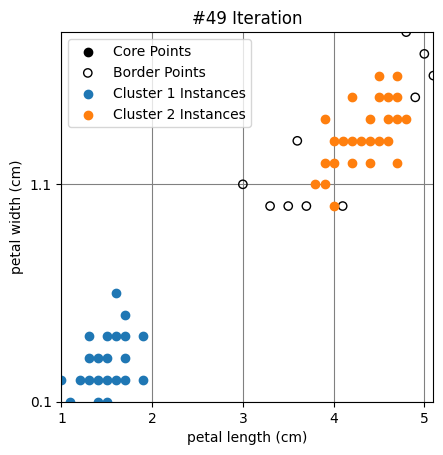

In [4]:
model_from_scratch = DBSCANFromScratch(eps=0.20)

y_pred = model_from_scratch.fit_predict(X, create_animation=True)

print(f"Adjusted Rand Index: {adjusted_rand_score(y, y_pred)}")

In [5]:
model = DBSCAN(eps=0.20)

y_pred = model.fit_predict(X)

print(f"Adjusted Rand Index: {adjusted_rand_score(y, y_pred)}")

Adjusted Rand Index: 0.6889628040678437
